In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
from nwnTorch.jn_models import *
from nwnTorch.nwn import *
from nwnTorch.generate_adj import *
from nwnTorch.misc import *

In [5]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
con = pkl_load("/home/rzhu/data_access/l2l_data/volterra_data/con0.pkl")
adj = torch.tensor(con["adj_matrix"])
# net = NWN(adj, "sydney")
lambda_dict = pkl_load("/home/rzhu/data_access/l2l_data/volterra_data/lambda_data.pkl")

In [7]:
maxG   = lambda_dict["maxG"]
minG   = lambda_dict["minG"]
netG   = lambda_dict["netG"]
readL0 = lambda_dict["lambda"]

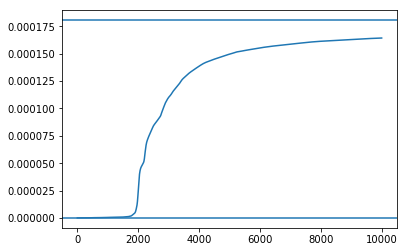

In [8]:
plt.axhline(maxG)
plt.plot(netG)
plt.axhline(minG)

In [9]:
from scipy.io import loadmat

In [10]:
MGdata = torch.tensor(loadmat("mackeyglass.mat")["datain"])

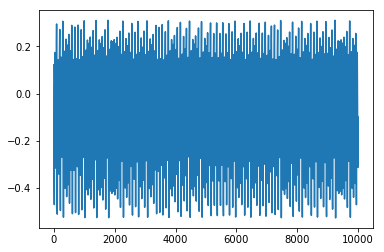

In [11]:
plt.plot(MGdata)

In [258]:
net                     = NWN(adj, "sydney")
E                       = net.number_of_junctions
N                       = net.number_of_nodes
net.params["Ron"]       = 1e4
net.params["grow"]      = 5
net.params["decay"]     = 10
net.params["precision"] = True
net.params["collapse"]  = True
net.params["dt"]        = 1e-3

T0                   = 2000
electrodes           = lambda_dict["electodes"]
net.junction_state.L = readL0[T0]
net.junction_state.updateG()

Tmax  = 5

# onAmp, b = 1.55, 0.2001 # * NLT non-ergodic
# onAmp, b = 0.05, 0.0001 # * NLT ergodic

onAmp, b = 5, 2
# onAmp, b = 1.2, 0.001
f     = 2
T     = torch.arange(0,Tmax,1e-3)
T_l   = len(T)

sig   = MGdata * onAmp + b

readI = torch.zeros(T_l, 1)
readG = torch.zeros(T_l, E)
readL = torch.zeros(T_l, E)
readV = torch.zeros(T_l, N)
netG2 = torch.zeros(T_l)

for t in tqdm(range(T_l)):
    sig_in = torch.zeros(len(electrodes))
    sig_in[0] = sig[t]

    net.sim(sig_in.reshape(1,-1), electrodes)
    readI[t,:] = net.I[-1:]
    # readG[t,:] = net.test_conductance(electrodes)
    readG[t,:] = net.junction_state.G[:]
    readL[t,:] = net.junction_state.L[:]
    readV[t,:] = net.V
    netG2[t] = net.I[-1] / sig[t]

100%|██████████| 5000/5000 [00:37<00:00, 132.08it/s]


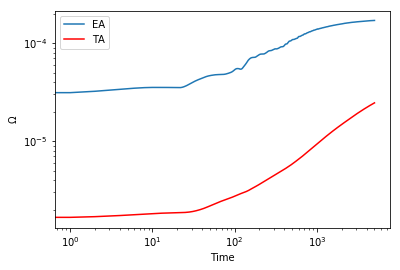

In [259]:
net_norm  = minG 
indi_norm = 1/net.params["Roff"]

EA = netG2
TA = (torch.cumsum(readG, axis = 0) / torch.arange(1,T_l+1).reshape(T_l,-1)).mean(axis = 1)

# EA = netG2 / net_norm
# TA = (torch.cumsum(readG/indi_norm, axis = 0) / torch.arange(1,T_l+1).reshape(T_l,-1)).mean(axis = 1)

# EA_norm = EA / EA.max()
# TA_norm = TA / TA.max()

# EA_norm = EA / (max(EA) - min(EA))
# TA_norm = TA / (max(TA) - min(TA))

# EA_norm = EA / EA[0]
# TA_norm = TA / TA[0]

# EA_norm = (EA-(EA).min())/ (max(EA) - min(EA))
# TA_norm = (TA-(TA).min())/ (max(TA) - min(TA))

plt.plot(EA, label = "EA")
# plt.twinx()
plt.plot(TA, c = "r", label = "TA")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Time")
plt.ylabel(r"$\Omega$")
plt.legend()

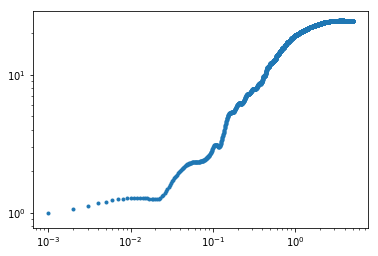

In [260]:
omegaTM = (TA - EA)**2
rate = omegaTM/omegaTM[1]
plt.plot(T, rate, marker = '.', ls = "none")

plt.yscale("log")
plt.xscale("log")

In [261]:
torch.manual_seed(0)
elec_out = torch.randint(N, (1,100))

In [262]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel

In [263]:
pred_steps = 5

lhs = readV[:,elec_out.reshape(-1)]
# rhs = sig[pred_steps:5000+pred_steps].type(torch.float32).reshape(-1)
rhs = MGdata[pred_steps:5000+pred_steps].type(torch.float32).reshape(-1)

train_range = np.arange(500,4000)
test_range  = np.arange(4000,5000)
whole_range = np.concatenate((train_range, test_range))

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1]
# model      = linear_model.RidgeCV(alphas=alphas)
model = linear_model.Ridge(alpha = 1e-2)
var_filter = SelectFromModel(model)
reg        = make_pipeline(
                StandardScaler(),
                var_filter, 
                model
                )

reg.fit(lhs[train_range], rhs[train_range])

predict = torch.tensor(reg.predict(lhs))
score = reg.score(lhs[test_range], rhs[test_range])
print(score)

0.5261572239754806


In [264]:
# plt.figure(figsize = (20,5))
# plt.plot(whole_range, predict[500:], label = "predict", ms = 5)
# plt.plot(rhs, label = "target")
# plt.axvline(4000, ls = "--", c = "k")


# plt.xlabel("steps")
# plt.ylabel("Voltage (V)")
# plt.legend()
# plt.title(f"sklearn score (1-NMSE, high is good): {score :.3}")

Text(0.5, 1.0, 'sklearn score (1-NMSE, high is good): 0.526')

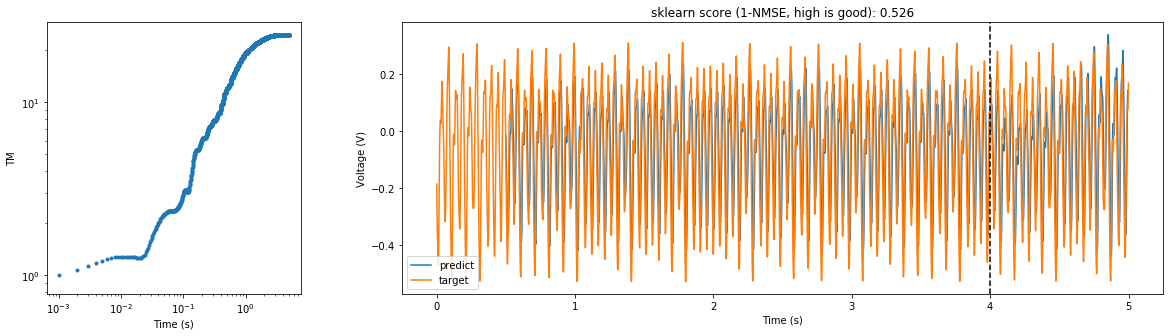

In [265]:
fig, axes = plt.subplots(1, 2, 
               figsize = (20, 5),
               gridspec_kw={'width_ratios': [1, 3]})

axes[0].plot(T, rate, marker = '.', ls = "none")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("TM")


axes[1].plot(whole_range/1000, predict[500:], label = "predict", ms = 5)
axes[1].plot(np.arange(0,5,1e-3),rhs, label = "target")
axes[1].axvline(4, ls = "--", c = "k")


axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Voltage (V)")
axes[1].legend()
axes[1].set_title(f"sklearn score (1-NMSE, high is good): {score :.3}")

Text(0.5, 1.0, 'sklearn score (1-NMSE, high is good): -0.438')

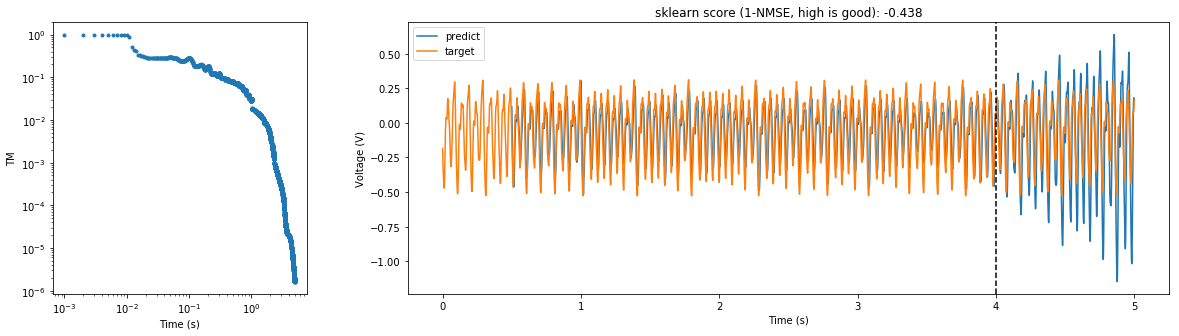

In [257]:
fig, axes = plt.subplots(1, 2, 
               figsize = (20, 5),
               gridspec_kw={'width_ratios': [1, 3]})

axes[0].plot(T, rate, marker = '.', ls = "none")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("TM")


axes[1].plot(whole_range/1000, predict[500:], label = "predict", ms = 5)
axes[1].plot(np.arange(0,5,1e-3),rhs, label = "target")
axes[1].axvline(4, ls = "--", c = "k")


axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Voltage (V)")
axes[1].legend()
axes[1].set_title(f"sklearn score (1-NMSE, high is good): {score :.3}")